<a href="https://colab.research.google.com/github/PranjalMinocha/RL_Mario/blob/main/Double_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros

In [ ]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
import time
%matplotlib inline

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [5]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)

    # display.clear_output(wait=True)
    # display.display(pl.gcf())

In [6]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env)  # Wraps the environment so that frames are grayscale 
obs = env.reset()

In [7]:
class Q_Agent():

    def __init__(self):
        """ initializing the class"""
        self.state_a_dict = {}
        self.Q_target = {}
        self.copy_steps = 10
        self.exploreP = 1
        self.obs_vec = []
        self.gamma = 0.99
        self.alpha = 0.01
        
    def obs_to_state(self, obs):
        state = -1
        for i in range(len(self.obs_vec)):
            if((obs == self.obs_vec[i]).all()):
                state = i
                break
        if(state == -1):
            state = len(self.obs_vec)
            self.obs_vec.append(obs)
        return state

    def take_action(self, state):
        Q_a = self.get_Qval(state)
        if(np.random.rand() > self.exploreP):
            """ exploitation"""
            action = np.argmax(Q_a)
        else:
            """ exploration"""
            action = env.action_space.sample()
        self.exploreP *= 0.99
        return action
    
    def get_Qval(self, state):
        if(state not in self.state_a_dict):
            self.state_a_dict[state] = np.random.rand(5,1)
        return self.state_a_dict[state]

    def get_Qtarget(self, state):
        if(state not in self.Q_target):
            self.Q_target[state] = np.random.rand(5,1)
        return self.Q_target[state]
    
    def update_Qval(self, state, action, reward, next_state, terminal):
        if terminal:
            TD_target = reward
        else:
            TD_target = reward + self.gamma*np.amax(self.get_Qtarget(next_state))
        
        td_error = TD_target - self.get_Qval(state)[action]
        self.state_a_dict[state][action] += self.alpha*td_error
    
    def copy(self):
        self.Q_target = self.state_a_dict.copy()

In [ ]:
num_episodes = 2000
Mario = Q_Agent()
rewards = []
num_steps = 0
for i_episode in range(num_episodes):
    obs = env.reset()
    state = Mario.obs_to_state(obs)
    episode_reward = 0
    while True:
        action = Mario.take_action(state)
        next_obs, reward, terminal, _ = env.step(action)
        episode_reward += reward

        num_steps += 1
        if(num_steps % Mario.copy_steps == 0):
            Mario.copy()

        next_state = Mario.obs_to_state(next_obs)

        Mario.update_Qval(state, action, reward, next_state, terminal)
        state = next_state

        if terminal:
            break
    rewards.append(episode_reward)
    print("Total reward after episode {} is {}".format(i_episode+1, episode_reward))
    #Saving the reward array and Q-table every 10 episodes
    if(i_episode%10 == 0):
      np.save('/content/drive/MyDrive/Mario RL/dqlrewards.npy',rewards)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

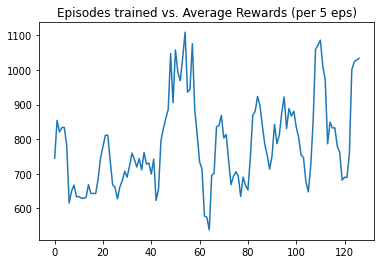

In [4]:
rewards = np.load('/content/drive/MyDrive/Mario RL/dqlrewards.npy')

plt.title("Episodes trained vs. Average Rewards (per 5 eps)")
plt.plot(np.convolve(rewards, np.ones((5,))/5, mode="valid").tolist())
plt.show()